In [3]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Text feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# Save model
import joblib


In [2]:
pip install seaborn


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# step2: load the data

In [4]:
# Load the metadata and review files
meta_df = pd.read_csv("Zomato Restaurant names and Metadata.csv")
review_df = pd.read_csv("Zomato Restaurant reviews.csv")

# Preview the datasets
print("Metadata sample:")
print(meta_df.head())

print("\nReview data sample:")
print(review_df.head())


Metadata sample:
                             Name  \
0                 Beyond Flavours   
1                        Paradise   
2                        Flechazo   
3  Shah Ghouse Hotel & Restaurant   
4      Over The Moon Brew Company   

                                               Links   Cost  \
0  https://www.zomato.com/hyderabad/beyond-flavou...    800   
1  https://www.zomato.com/hyderabad/paradise-gach...    800   
2  https://www.zomato.com/hyderabad/flechazo-gach...  1,300   
3  https://www.zomato.com/hyderabad/shah-ghouse-h...    800   
4  https://www.zomato.com/hyderabad/over-the-moon...  1,200   

                                         Collections  \
0  Food Hygiene Rated Restaurants in Hyderabad, C...   
1                                Hyderabad's Hottest   
2                 Great Buffets, Hyderabad's Hottest   
3                             Late Night Restaurants   
4  Best Bars & Pubs, Food Hygiene Rated Restauran...   

                                            

# step 3: Merge the data

In [7]:
# Rename columns for clarity
meta_df.rename(columns={"Name": "Restaurant Name"}, inplace=True)
review_df.rename(columns={"Restaurant": "Restaurant Name"}, inplace=True)

# Merge the datasets on 'Restaurant Name'
merged_df = pd.merge(meta_df, review_df, on="Restaurant Name", how="left")

# Preview merged data
print(merged_df.head())



   Restaurant Name                                              Links Cost  \
0  Beyond Flavours  https://www.zomato.com/hyderabad/beyond-flavou...  800   
1  Beyond Flavours  https://www.zomato.com/hyderabad/beyond-flavou...  800   
2  Beyond Flavours  https://www.zomato.com/hyderabad/beyond-flavou...  800   
3  Beyond Flavours  https://www.zomato.com/hyderabad/beyond-flavou...  800   
4  Beyond Flavours  https://www.zomato.com/hyderabad/beyond-flavou...  800   

                                         Collections  \
0  Food Hygiene Rated Restaurants in Hyderabad, C...   
1  Food Hygiene Rated Restaurants in Hyderabad, C...   
2  Food Hygiene Rated Restaurants in Hyderabad, C...   
3  Food Hygiene Rated Restaurants in Hyderabad, C...   
4  Food Hygiene Rated Restaurants in Hyderabad, C...   

                                            Cuisines  \
0  Chinese, Continental, Kebab, European, South I...   
1  Chinese, Continental, Kebab, European, South I...   
2  Chinese, Continental, K

# Step 4: Data Cleaning 

In [8]:
merged_df['Cost'] = merged_df['Cost'].replace('[₹,]', '', regex=True).astype(float)


In [9]:
merged_df['Rating'] = pd.to_numeric(merged_df['Rating'], errors='coerce')  # Converts to float, handles non-numeric


In [10]:
#Handling missing values


# Count missing values
print(merged_df.isnull().sum())

# Drop rows with missing target (Rating)
merged_df.dropna(subset=['Rating'], inplace=True)

# Fill missing reviews with empty string
merged_df['Review'] = merged_df['Review'].fillna("")

# Optional: Fill missing cost with median
merged_df['Cost'] = merged_df['Cost'].fillna(merged_df['Cost'].median())


Restaurant Name       0
Links                 0
Cost                  0
Collections        5004
Cuisines              0
Timings             100
Reviewer             43
Review               50
Rating               44
Metadata             43
Time                 43
Pictures              5
dtype: int64


In [13]:
print(merged_df.dtypes)
print(merged_df.head())


Restaurant Name     object
Cost               float64
Collections         object
Cuisines            object
Timings             object
Reviewer            object
Review              object
Rating             float64
Metadata            object
Time                object
dtype: object
   Restaurant Name   Cost                                        Collections  \
0  Beyond Flavours  800.0  Food Hygiene Rated Restaurants in Hyderabad, C...   
1  Beyond Flavours  800.0  Food Hygiene Rated Restaurants in Hyderabad, C...   
2  Beyond Flavours  800.0  Food Hygiene Rated Restaurants in Hyderabad, C...   
3  Beyond Flavours  800.0  Food Hygiene Rated Restaurants in Hyderabad, C...   
4  Beyond Flavours  800.0  Food Hygiene Rated Restaurants in Hyderabad, C...   

                                            Cuisines  \
0  Chinese, Continental, Kebab, European, South I...   
1  Chinese, Continental, Kebab, European, South I...   
2  Chinese, Continental, Kebab, European, South I...   
3  Chinese,

In [12]:
merged_df.drop(columns=['Pictures', 'Links'], inplace=True, errors='ignore')


# Step 5: EDA

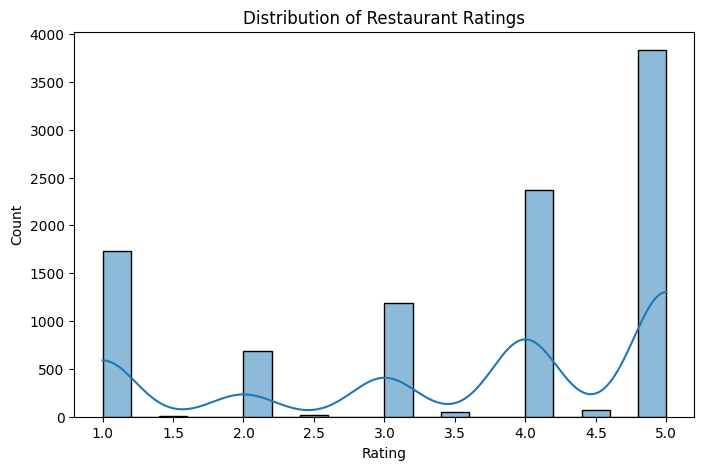

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.histplot(merged_df['Rating'], bins=20, kde=True)
plt.title('Distribution of Restaurant Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


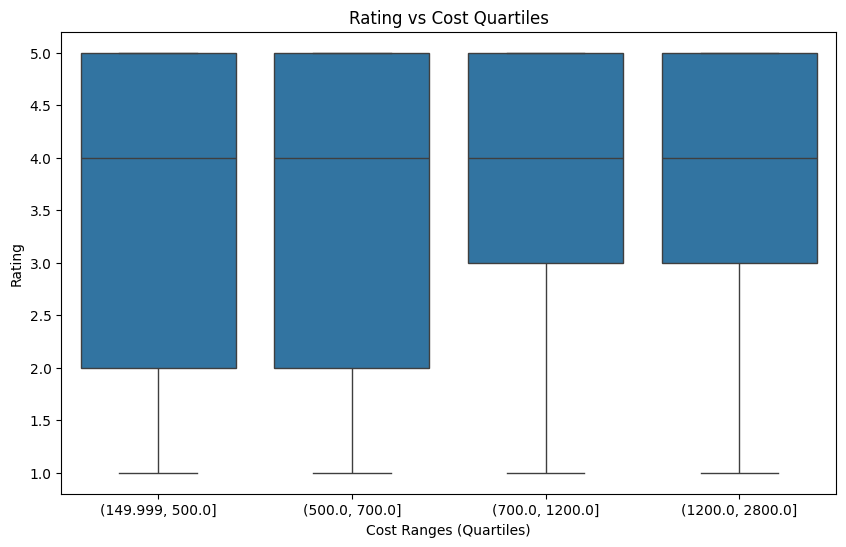

In [15]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=pd.qcut(merged_df['Cost'], q=4), y='Rating', data=merged_df)
plt.title('Rating vs Cost Quartiles')
plt.xlabel('Cost Ranges (Quartiles)')
plt.ylabel('Rating')
plt.show()


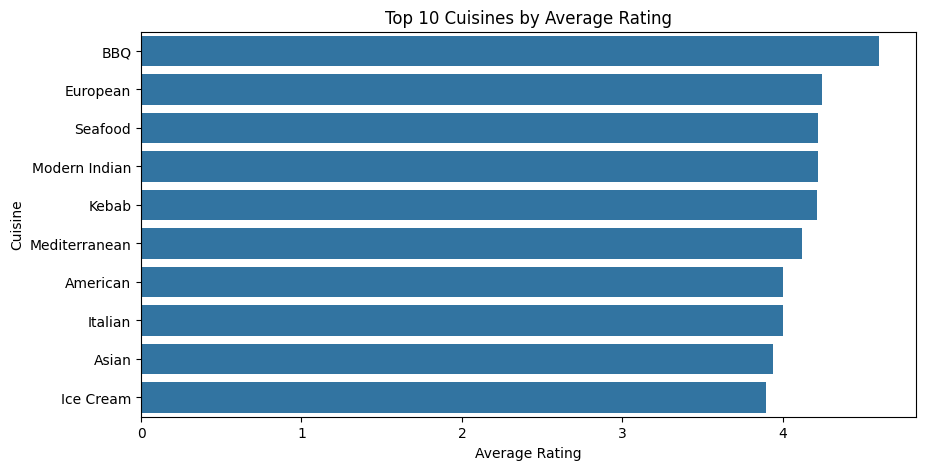

In [16]:
# Extract first cuisine (simplified view)
merged_df['Primary Cuisine'] = merged_df['Cuisines'].str.split(',').str[0]

# Group and plot
top_cuisines = (
    merged_df.groupby('Primary Cuisine')['Rating']
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_cuisines.values, y=top_cuisines.index)
plt.title('Top 10 Cuisines by Average Rating')
plt.xlabel('Average Rating')
plt.ylabel('Cuisine')
plt.show()


# EDA vs count per cuisine

In [21]:
merged_df['primary_cuisine'] = merged_df['Cuisines'].str.split(',').str[0].str.strip()



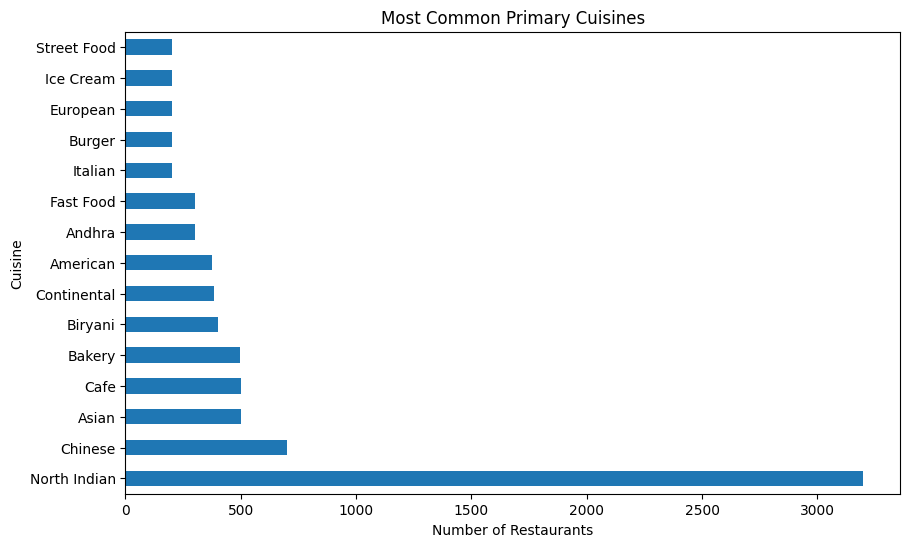

In [22]:
plt.figure(figsize=(10, 6))
merged_df['primary_cuisine'].value_counts().head(15).plot(kind='barh')
plt.title('Most Common Primary Cuisines')
plt.xlabel('Number of Restaurants')
plt.ylabel('Cuisine')
plt.show()



In [25]:
print(merged_df.columns.tolist())



['Restaurant Name', 'Cost', 'Collections', 'Cuisines', 'Timings', 'Reviewer', 'Review', 'Rating', 'Metadata', 'Time', 'Primary Cuisine', 'primary_cuisine']


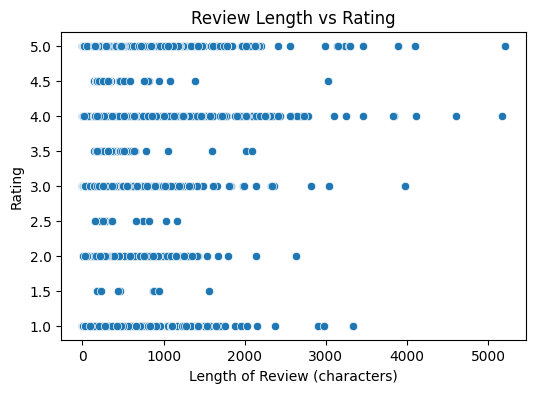

In [27]:
merged_df['review_length'] = merged_df['Review'].fillna("").apply(len)

plt.figure(figsize=(6, 4))
sns.scatterplot(x='review_length', y='Rating', data=merged_df)
plt.title("Review Length vs Rating")
plt.xlabel("Length of Review (characters)")
plt.ylabel("Rating")
plt.show()


In [33]:

print("Hello")


Hello


In [37]:
emoji_rows = merged_df[merged_df['Review'].str.contains(r'[^\x00-\x7F]', na=False)]
print(emoji_rows[['Review']].head(10))


                                               Review
21  please was good but it was quite expensive and...
25  The place is very good.. 5* to the live music....
26  Sonalin has a great voice.. 😍 must visit the p...
27  I heard her voice..she is too beautiful with a...
28  Sonalin is a very good singer in the city.. be...
30  Short review: Decent breads and starters, bad ...
37  The food was ❤️.. We ordered banjara tangdi fo...
40  Well we’re new to Hyderabad . And I can for a ...
43  My review of the place comes after multiple vi...
56  We went for lunch buffet yesterday and took a ...


In [38]:
import re

def remove_emojis(text):
    if isinstance(text, str):
        return re.sub(r'[^\x00-\x7F]+', '', text)  # remove non-ASCII
    return text

merged_df['Review'] = merged_df['Review'].apply(remove_emojis)



In [35]:
print('ko')

ko


C:\Users\USER\AppData\Local\Temp\ipykernel_13092\2128411248.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='review_length_group', y='Rating', data=merged_df, palette='pastel')


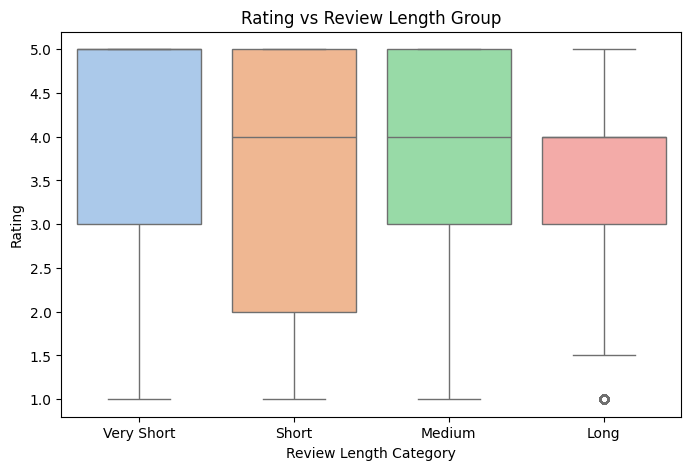

In [41]:


# Create bins for review lengths
bins = [0, 50, 150, 300, 1000]
labels = ['Very Short', 'Short', 'Medium', 'Long']
merged_df['review_length_group'] = pd.cut(merged_df['review_length'], bins=bins, labels=labels)

# Boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x='review_length_group', y='Rating', data=merged_df, palette='pastel')
plt.title("Rating vs Review Length Group")
plt.xlabel("Review Length Category")
plt.ylabel("Rating")
plt.show()


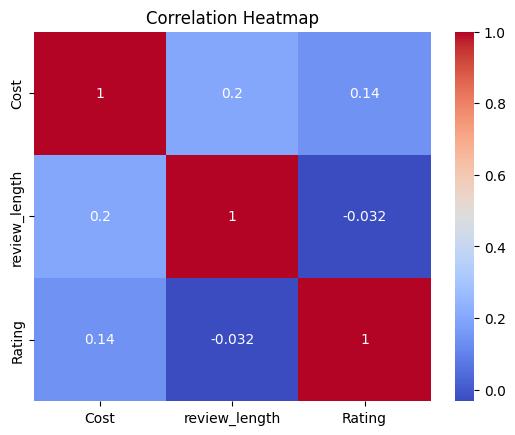

In [44]:
sns.heatmap(merged_df[['Cost', 'review_length', 'Rating']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


In [45]:
print(merged_df.columns.tolist())


['Restaurant Name', 'Cost', 'Collections', 'Cuisines', 'Timings', 'Reviewer', 'Review', 'Rating', 'Metadata', 'Time', 'Primary Cuisine', 'primary_cuisine', 'review_length', 'review_length_group']


C:\Users\USER\AppData\Local\Temp\ipykernel_13092\705271540.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=tags, palette='viridis')


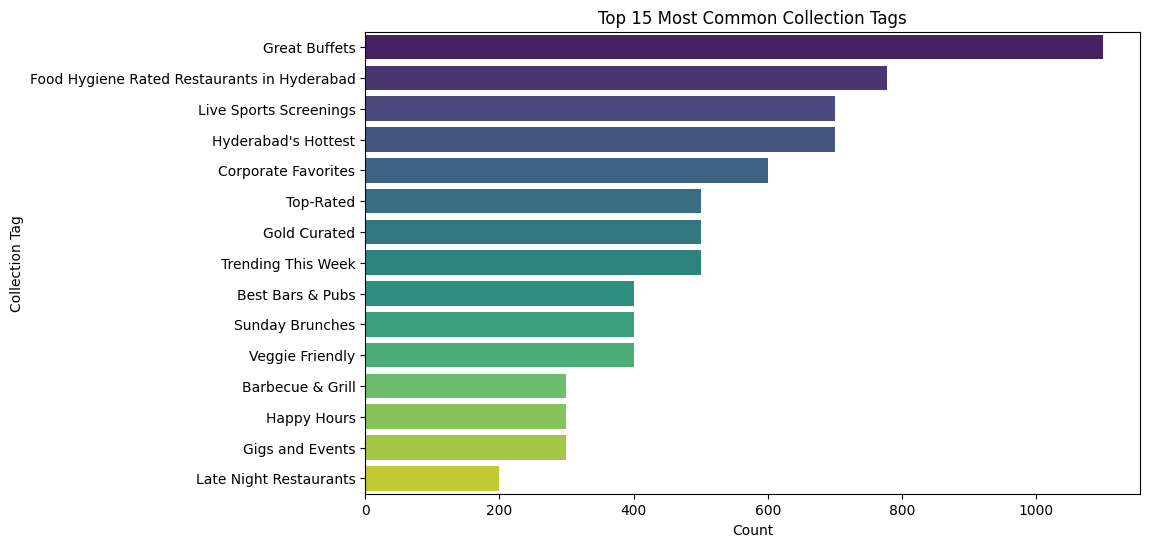

In [46]:
from collections import Counter

# Drop NaNs and split each string into tags
all_collections = merged_df['Collections'].dropna().str.split(',')

# Flatten and clean
flat_tags = [tag.strip() for sublist in all_collections for tag in sublist]

# Count
tag_counts = Counter(flat_tags)
top_tags = tag_counts.most_common(15)

# Plot
tags, counts = zip(*top_tags)
plt.figure(figsize=(10, 6))
sns.barplot(x=counts, y=tags, palette='viridis')
plt.title("Top 15 Most Common Collection Tags")
plt.xlabel("Count")
plt.ylabel("Collection Tag")
plt.show()


C:\Users\USER\AppData\Local\Temp\ipykernel_13092\1537974884.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='avg_rating', y='tag', data=filtered, palette='coolwarm')


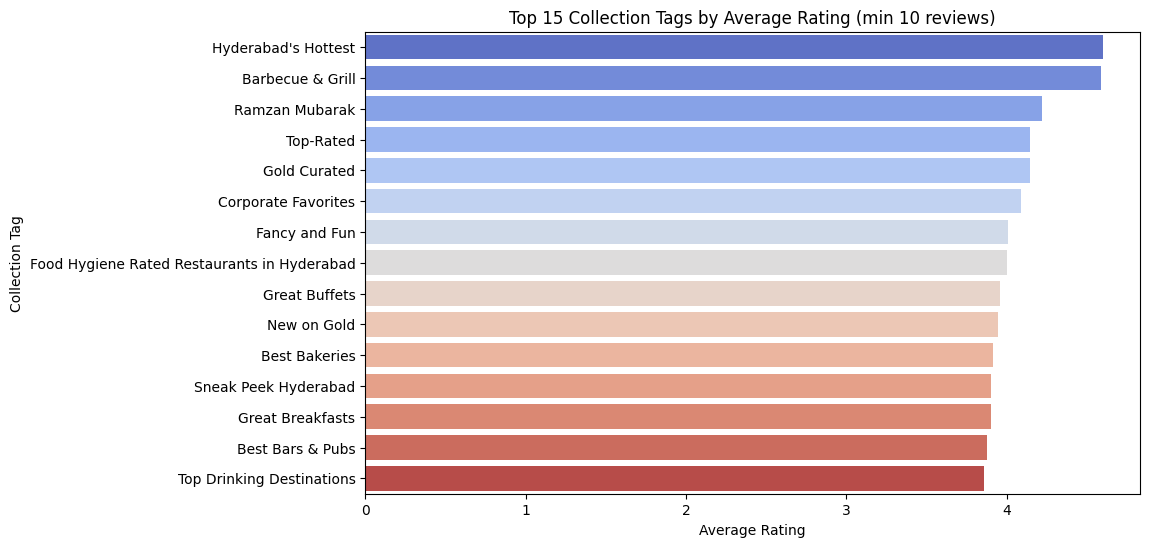

In [47]:
# Create a DataFrame to collect tag-wise ratings
tag_rating = {}

for i, row in merged_df.iterrows():
    if pd.notnull(row['Collections']):
        tags = [tag.strip() for tag in row['Collections'].split(',')]
        for tag in tags:
            tag_rating.setdefault(tag, []).append(row['Rating'])

# Convert to DataFrame
tag_rating_df = pd.DataFrame({
    'tag': list(tag_rating.keys()),
    'avg_rating': [sum(ratings)/len(ratings) for ratings in tag_rating.values()],
    'count': [len(ratings) for ratings in tag_rating.values()]
})

# Top tags by average rating (min 10 reviews for stability)
filtered = tag_rating_df[tag_rating_df['count'] >= 10].sort_values('avg_rating', ascending=False).head(15)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='avg_rating', y='tag', data=filtered, palette='coolwarm')
plt.title("Top 15 Collection Tags by Average Rating (min 10 reviews)")
plt.xlabel("Average Rating")
plt.ylabel("Collection Tag")
plt.show()


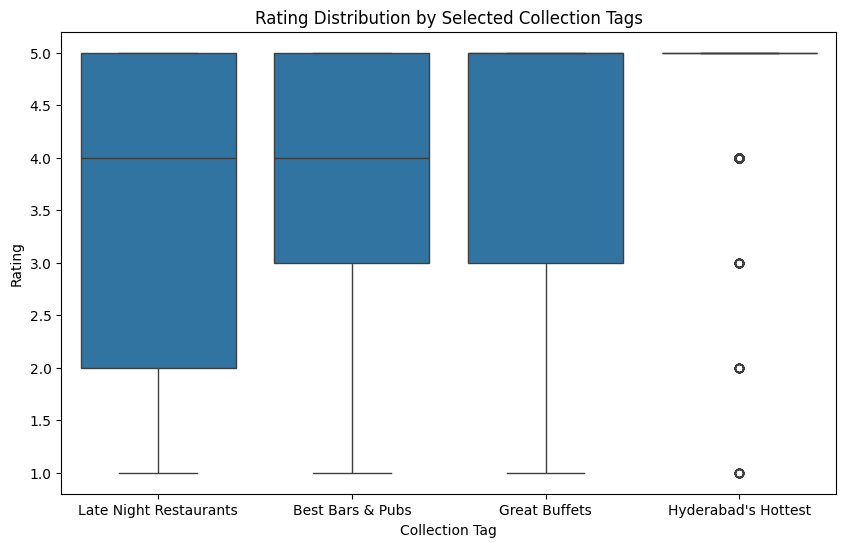

In [51]:
# Pick common tags
selected_tags = ['Late Night Restaurants', 'Best Bars & Pubs', 'Family Dining', 'Great Buffets',"Hyderabad's Hottest"]

# Create a new column: collection_tag for each selected tag (1 or 0)
for tag in selected_tags:
    merged_df[tag] = merged_df['Collections'].fillna('').apply(lambda x: 1 if tag in x else 0)

# Melt the data for seaborn boxplot
melted = merged_df.melt(id_vars='Rating', value_vars=selected_tags, var_name='collection_tag')
melted = melted[melted['value'] == 1]

# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='collection_tag', y='Rating', data=melted)
plt.title("Rating Distribution by Selected Collection Tags")
plt.xlabel("Collection Tag")
plt.ylabel("Rating")
plt.show()


# Hypothesis Testing

In [52]:
from scipy.stats import f_oneway
import pandas as pd

# Create cost quartile column
merged_df['cost_quartile'] = pd.qcut(merged_df['Cost'], q=4)

# Group ratings by cost quartiles
groups_cost = [group['Rating'].dropna() for _, group in merged_df.groupby('cost_quartile')]

# Perform One-way ANOVA
f_stat1, p_value1 = f_oneway(*groups_cost)

print("Hypothesis Test 1 - Cost vs Rating")
print("F-statistic:", f_stat1)
print("P-value:", p_value1)


Hypothesis Test 1 - Cost vs Rating
F-statistic: 74.99930410021805
P-value: 5.7715297869181e-48


C:\Users\USER\AppData\Local\Temp\ipykernel_13092\3225972536.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups_cost = [group['Rating'].dropna() for _, group in merged_df.groupby('cost_quartile')]


In [53]:
# Define review length categories
def categorize_length(x):
    if x < 100:
        return 'Very Short'
    elif x < 300:
        return 'Short'
    elif x < 700:
        return 'Medium'
    else:
        return 'Long'

merged_df['review_length'] = merged_df['Review'].fillna("").apply(len)
merged_df['review_length_group'] = merged_df['review_length'].apply(categorize_length)

# Group ratings by review length category
groups_review = [group['Rating'].dropna() for _, group in merged_df.groupby('review_length_group')]

# Perform One-way ANOVA
f_stat2, p_value2 = f_oneway(*groups_review)

print("\nHypothesis Test 2 - Review Length vs Rating")
print("F-statistic:", f_stat2)
print("P-value:", p_value2)



Hypothesis Test 2 - Review Length vs Rating
F-statistic: 16.179797410888654
P-value: 1.7300595040439633e-10


In [56]:
# Select few common collection tags
selected_tags = ['Late Night Restaurants', 'Great Buffets', 'Hyderabadis Love', 'Best Bars in Town']

# Create a filtered DataFrame for selected tags
filtered_df = merged_df[merged_df['Collections'].isin(selected_tags)]

# Group ratings by selected collection tags
groups_collections = [group['Rating'].dropna() for _, group in filtered_df.groupby('Collections')]

# Perform One-way ANOVA
f_stat3, p_value3 = f_oneway(*groups_collections)

print("\nHypothesis Test 3 - Collection Tags vs Rating")
print("F-statistic:", f_stat3)
print("P-value:", p_value3)



Hypothesis Test 3 - Collection Tags vs Rating
F-statistic: 5.980824534865752
P-value: 0.015040755627054493


In [57]:
# Count how many times each reviewer appears
top_reviewers = merged_df['Reviewer'].value_counts().head(10).index.tolist()

# Filter to only top reviewers
filtered_df = merged_df[merged_df['Reviewer'].isin(top_reviewers)]

# Group by reviewer
from scipy.stats import f_oneway

groups_by_reviewer = [
    group['Rating'].dropna() 
    for _, group in filtered_df.groupby('Reviewer')
]

# Run one-way ANOVA
f_stat, p_value = f_oneway(*groups_by_reviewer)

print("Hypothesis Test 4 - Reviewer vs Rating")
print("F-statistic:", f_stat)
print("P-value:", p_value)


Hypothesis Test 4 - Reviewer vs Rating
F-statistic: 3.255319167454337
P-value: 0.0016489481151602636


In [61]:
def categorize_timing(Timings):
    if isinstance(Timings, str):  # only process if timing is a string
        if '12noon' in Timings.lower() and '11pm' in Timings.lower():
            return 'Full Day'
        elif 'lunch' in Timings.lower() or '12noon' in Timings.lower():
            return 'Lunch Time'
        elif '11 am' in Timings.lower():
            return 'Early Open'
        else:
            return 'Other'
    else:
        return 'Unknown'



In [62]:
merged_df['Timing_Category'] = merged_df['Timings'].apply(categorize_timing)


In [63]:
from scipy.stats import f_oneway

groups_timing = [group['Rating'].dropna() for _, group in merged_df.groupby('Timing_Category')]
f_stat, p_val = f_oneway(*groups_timing)

print("F-statistic:", f_stat)
print("P-value:", p_val)


F-statistic: 12.12699838133397
P-value: 7.807349193072933e-10


In [64]:
from scipy.stats import f_oneway

# Group ratings by restaurant name
groups_rest_name = [group['Rating'].dropna() for _, group in merged_df.groupby('Restaurant Name') if len(group) > 1]

# Perform ANOVA test
f_stat_rest, p_val_rest = f_oneway(*groups_rest_name)

print("Hypothesis Test 6 - Restaurant Name vs Rating")
print("F-statistic:", f_stat_rest)
print("P-value:", p_val_rest)


Hypothesis Test 6 - Restaurant Name vs Rating
F-statistic: 13.093463514602433
P-value: 3.246896466093148e-193


# Feature engineering and data preprocessing 

In [65]:
import string
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split

In [66]:
# --- 1. Handling Missing Values ---

# Fill categorical features with mode
categorical_cols = ['Reviewer', 'Collections', 'Timings']
for col in categorical_cols:
    merged_df[col] = merged_df[col].fillna(merged_df[col].mode()[0])

# Fill numerical features with median
numerical_cols = ['Cost', 'Rating']
for col in numerical_cols:
    merged_df[col] = merged_df[col].fillna(merged_df[col].median())


In [67]:
# --- 2. Handling Outliers ---

# Capping Cost outliers using IQR
Q1 = merged_df['Cost'].quantile(0.25)
Q3 = merged_df['Cost'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR
merged_df['Cost'] = np.where(merged_df['Cost'] > upper_bound, upper_bound, merged_df['Cost'])
merged_df['Cost'] = np.where(merged_df['Cost'] < lower_bound, lower_bound, merged_df['Cost'])


In [68]:
print(merged_df.columns.tolist())


['Restaurant Name', 'Cost', 'Collections', 'Cuisines', 'Timings', 'Reviewer', 'Review', 'Rating', 'Metadata', 'Time', 'Primary Cuisine', 'primary_cuisine', 'review_length', 'review_length_group', 'Late Night Restaurants', 'Best Bars & Pubs', 'Family Dining', 'Great Buffets', "Hyderabad's Hottest", 'cost_quartile', 'Timing_Category']


In [69]:
# --- 3. Categorical Encoding ---

le = LabelEncoder()
merged_df['Reviewer_encoded'] = le.fit_transform(merged_df['Reviewer'])

# One-Hot Encoding for Collections
ohe = pd.get_dummies(merged_df['Collections'], prefix='collection')
merged_df = pd.concat([merged_df, ohe], axis=1)


In [72]:
# --- 4. Textual Data Preprocessing ---

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...


In [71]:
pip install nltk


   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------------- -------------------------- 0.5/1.5 MB 932.9 kB/s eta 0:00:02
   -------------------- ------------------- 0.8/1.5 MB 1.0 MB/s eta 0:00:01
   --------------------------- ------------ 1.0/1.5 MB 1.0 MB/s eta 0:00:01
   --------------------------- ------------ 1.0/1.5 MB 1.0 MB/s eta 0:00:01
   --------------------------- ------------ 1.0/1.5 MB 1.0 MB/s eta 0:00:01
   ---------------------------------- ----- 1.3/1.5 MB 780.8 kB/s eta 0:00:01
   ---------------------------------- ----- 1.3/1.5 MB 780.8 kB/s eta 0:00:01
   ---------------------------------- ----- 1.3/1.5 MB 780.8 kB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 631.8 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [73]:
# Clean review text
def preprocess_review(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

merged_df['Cleaned_Review'] = merged_df['Review'].fillna('').apply(preprocess_review)

# Vectorize Review Text
tfidf = TfidfVectorizer(max_features=200)
tfidf_matrix = tfidf.fit_transform(merged_df['Cleaned_Review'])

# Dimensionality reduction on TF-IDF vectors
svd = TruncatedSVD(n_components=50)
tfidf_reduced = svd.fit_transform(tfidf_matrix)
tfidf_df = pd.DataFrame(tfidf_reduced, columns=[f'tfidf_{i}' for i in range(50)])
merged_df = pd.concat([merged_df.reset_index(drop=True), tfidf_df], axis=1)


In [74]:
# Drop only if these have been processed or replaced
drop_cols = []

if 'Reviewer_Encoded' in merged_df.columns:
    drop_cols.append('Reviewer')

if any(col.startswith('Collection_') for col in merged_df.columns):
    drop_cols.append('Collections')

if 'Timing_Category' in merged_df.columns:
    drop_cols.append('Timings')

if any(col.startswith('SVD_') for col in merged_df.columns):  # review vectorization done
    drop_cols.extend(['Review', 'Cleaned_Review'])

merged_df.drop(columns=drop_cols, inplace=True)


In [76]:
X = merged_df.drop('Rating', axis=1)
y = merged_df['Rating']


In [77]:
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include='object').columns


In [78]:
from sklearn.preprocessing import StandardScaler

X_numeric = X[numeric_cols]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)
X_scaled_df = pd.DataFrame(X_scaled, columns=numeric_cols)


In [79]:
X_categorical = X[categorical_cols]
X_encoded = pd.get_dummies(X_categorical, drop_first=True)


In [80]:
import pandas as pd

X_final = pd.concat([X_scaled_df.reset_index(drop=True),
                     X_encoded.reset_index(drop=True)],
                    axis=1)


In [81]:
# --- 7. Data Splitting ---

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

print("Feature engineering and preprocessing complete.")


Feature engineering and preprocessing complete.


# Model 1 : Linear regression

In [86]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# --- STEP 0: Select only numeric columns (excluding Rating & Cleaned_Review) ---
numeric_cols = merged_df.select_dtypes(include=[np.number]).drop(columns=['Rating']).columns
scaler = StandardScaler()
scaled_features = scaler.fit_transform(merged_df[numeric_cols])

# --- STEP 1: TF-IDF Vectorization on Cleaned_Review ---
vectorizer = TfidfVectorizer(max_features=5000)  # limit dimensions
tfidf_matrix = vectorizer.fit_transform(merged_df['Cleaned_Review'].fillna(""))

# --- STEP 2: Dimensionality Reduction on TF-IDF matrix ---
svd = TruncatedSVD(n_components=100, random_state=42)
tfidf_reduced = svd.fit_transform(tfidf_matrix)

# --- STEP 3: Combine Scaled Numeric Features with Text Features ---
X_combined = np.hstack((scaled_features, tfidf_reduced))
y = merged_df['Rating']

# --- STEP 4: Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# --- STEP 5: Train Simple Ridge Regression Model ---
model = Ridge(alpha=1.0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# --- STEP 6: Evaluation ---
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("✅ Ridge Regression Model Trained")
print("MSE:", mse)
print("R² Score:", r2)


✅ Ridge Regression Model Trained
MSE: 0.9228549635548114
R² Score: 0.5792029540157683


In [87]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
import numpy as np

# Define model
ridge = Ridge(alpha=1.0)

# Perform 5-fold cross-validation on the full combined feature set
mse_scores = cross_val_score(ridge, X_combined, y, scoring='neg_mean_squared_error', cv=5)
r2_scores = cross_val_score(ridge, X_combined, y, scoring='r2', cv=5)

# Convert negative MSE to positive
mse_scores = -mse_scores

# Print results
print("Cross-Validation Results (5-Fold):")
print(f"Average MSE: {np.mean(mse_scores):.4f}")
print(f"Average R²: {np.mean(r2_scores):.4f}")


Cross-Validation Results (5-Fold):
Average MSE: 0.9048
Average R²: 0.5870


In [88]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

# Define range of alpha values to test
alpha_values = {'alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]}

# Ridge model
ridge = Ridge()

# GridSearch with 5-fold CV
grid_search = GridSearchCV(estimator=ridge,
                           param_grid=alpha_values,
                           scoring='neg_mean_squared_error',
                           cv=5,
                           n_jobs=-1)

# Fit on the full dataset
grid_search.fit(X_combined, y)

# Best alpha
best_alpha = grid_search.best_params_['alpha']
best_mse = -grid_search.best_score_

print(f"Best Alpha: {best_alpha}")
print(f"Best Cross-Validated MSE: {best_mse:.4f}")


Best Alpha: 0.5
Best Cross-Validated MSE: 0.9044


In [90]:
# Combine numeric + reduced TF-IDF text features
import numpy as np
from sklearn.model_selection import train_test_split

# Combine
X_combined = np.hstack((scaled_features, tfidf_reduced))
y = merged_df['Rating']

# Train-test split
X_train_combined, X_test_combined, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42
)



In [91]:
# Retrain with best alpha
final_model = Ridge(alpha=0.5)
final_model.fit(X_train_combined, y_train)

# Predict on test set
y_pred_final = final_model.predict(X_test_combined)

# Evaluate
final_mse = mean_squared_error(y_test, y_pred_final)
final_r2 = r2_score(y_test, y_pred_final)

print("✅ Final Ridge Regression Model Trained")
print(f"Final Test MSE: {final_mse:.4f}")
print(f"Final Test R² Score: {final_r2:.4f}")


✅ Final Ridge Regression Model Trained
Final Test MSE: 0.9224
Final Test R² Score: 0.5794


C:\Users\USER\AppData\Local\Temp\ipykernel_13092\3105488481.py:13: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


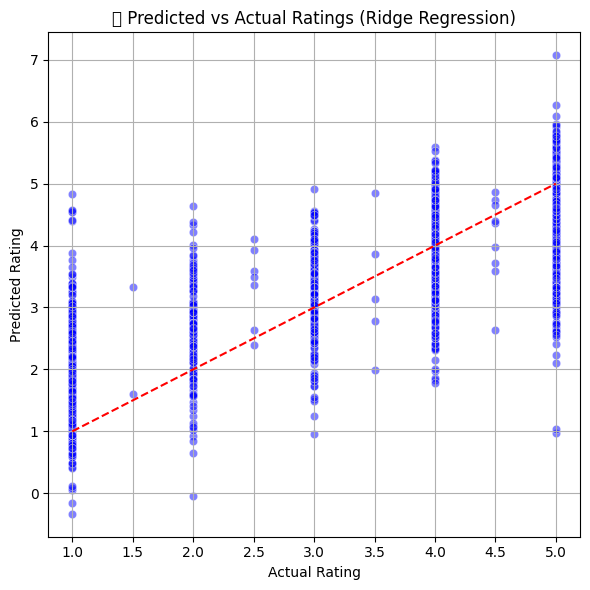

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predicted vs Actual
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred_final, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # perfect prediction line
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.title('📈 Predicted vs Actual Ratings (Ridge Regression)')
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\USER\AppData\Local\Temp\ipykernel_13092\3916490355.py:10: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


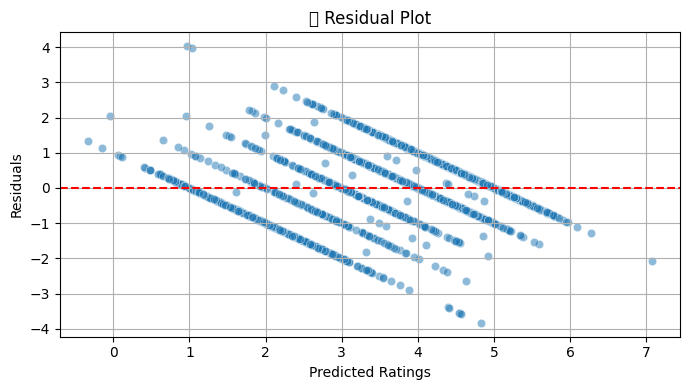

In [93]:
residuals = y_test - y_pred_final

plt.figure(figsize=(7,4))
sns.scatterplot(x=y_pred_final, y=residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Ratings')
plt.ylabel('Residuals')
plt.title('📉 Residual Plot')
plt.grid(True)
plt.tight_layout()
plt.show()


# Model 2: Random Forest

In [94]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)


In [95]:
rf_model.fit(X_train_combined, y_train)


,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [96]:
from sklearn.metrics import mean_squared_error, r2_score

# Predict
y_pred_rf = rf_model.predict(X_test_combined)

# Evaluate
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("📊 Random Forest Evaluation:")
print("MSE:", mse_rf)
print("R² Score:", r2_rf)


📊 Random Forest Evaluation:
MSE: 0.8886809428834253
R² Score: 0.594785388434857


In [99]:
# Perform 5-Fold Cross Validation with parallel processing
mse_scores = cross_val_score(rf_model, X_combined, y, cv=5, scoring=mse_scorer, n_jobs=-1)
r2_scores = cross_val_score(rf_model, X_combined, y, cv=5, scoring=r2_scorer, n_jobs=-1)

# Display results
print("🔁 5-Fold Cross-Validation Results (Random Forest):")
print(f"Average MSE: {np.mean(mse_scores):.4f}")
print(f"Average R² Score: {np.mean(r2_scores):.4f}")



🔁 5-Fold Cross-Validation Results (Random Forest):
Average MSE: 0.9226
Average R² Score: 0.5787


In [100]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize the model
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=3,
                           scoring='r2',
                           verbose=2)

# Run the grid search
grid_search.fit(X_combined, y)

# Get the best parameters and best score
print("✅ Best Parameters Found:", grid_search.best_params_)
print(f"✅ Best R² Score: {grid_search.best_score_:.4f}")


Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  10.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  12.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  11.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  23.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  26.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  25.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=  10.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=  13.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=  12.6s
[CV] END max_depth

In [101]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 1. Retrain the Random Forest with best hyperparameters
best_rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

best_rf_model.fit(X_train_combined, y_train)

# 2. Predict on test set
y_pred_rf = best_rf_model.predict(X_test_combined)

# 3. Evaluate
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("✅ Tuned Random Forest Model Evaluation:")
print(f"Test MSE: {mse_rf:.4f}")
print(f"Test R² Score: {r2_rf:.4f}")


✅ Tuned Random Forest Model Evaluation:
Test MSE: 0.8784
Test R² Score: 0.5995


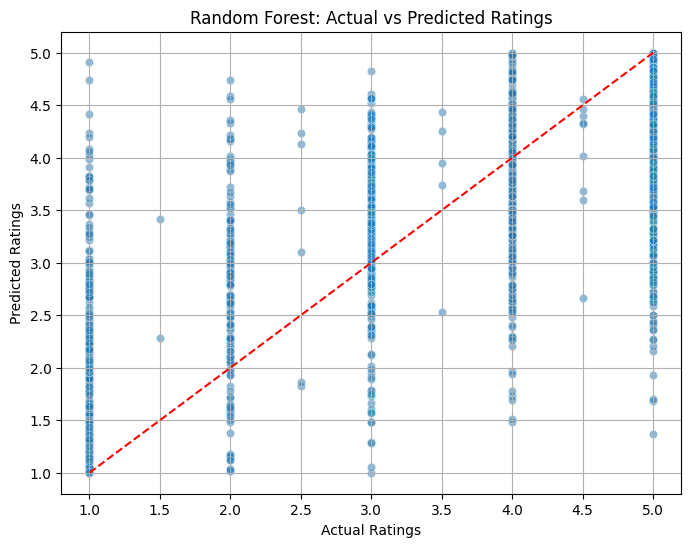

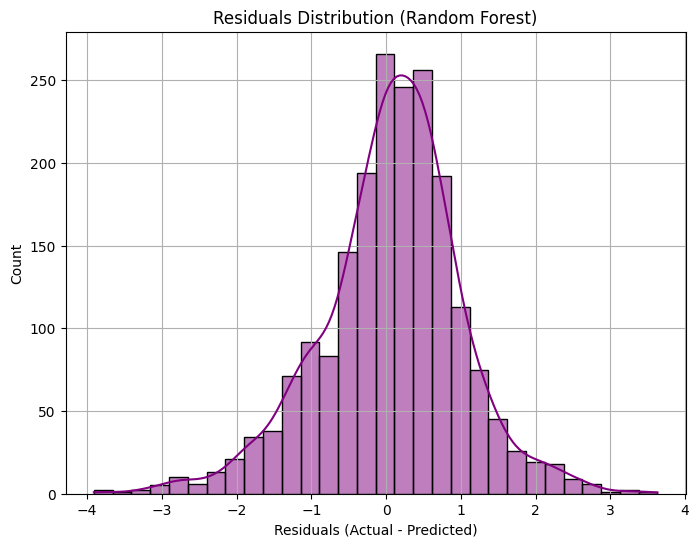

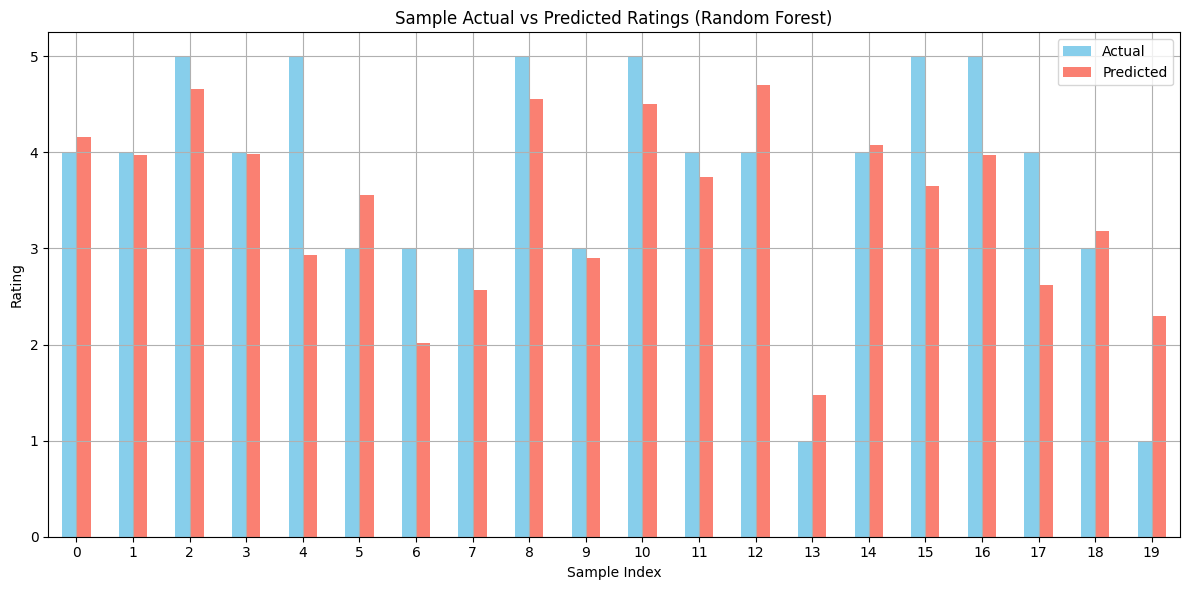

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

# Predict on test set using the correct model name
y_pred_rf = rf_model.predict(X_test_combined)

# --- 1. Scatter Plot: Actual vs Predicted ---
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Random Forest: Actual vs Predicted Ratings")
plt.grid(True)
plt.show()

# --- 2. Residual Plot ---
residuals = y_test - y_pred_rf
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30, color='purple')
plt.title("Residuals Distribution (Random Forest)")
plt.xlabel("Residuals (Actual - Predicted)")
plt.grid(True)
plt.show()

# --- 3. Bar Chart: Sample Predictions ---
comparison_df = pd.DataFrame({'Actual': y_test.values[:20], 'Predicted': y_pred_rf[:20]})
comparison_df.plot(kind='bar', figsize=(12, 6), color=['skyblue', 'salmon'])
plt.title("Sample Actual vs Predicted Ratings (Random Forest)")
plt.xlabel("Sample Index")
plt.ylabel("Rating")
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()


# Model 3: XGBoost Regressor

In [105]:
!pip install xgboost


   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/150.0 MB 670.4 kB/s eta 0:03:43
   ---------------------------------------- 0.5/150.0 MB 670.4 kB/s eta 0:03:43
   ---------------------------------------- 0.8/150.0 MB 621.2 kB/s eta 0:04:01
   ---------------------------------------- 0.8/150.0 MB 621.2 kB/s eta 0:04:01
   ---------------------------------------- 0.8/150.0 MB 621.2 kB/s eta 0:04:01
   ---------------------------------------- 0.8/150.0 MB 621.2 kB/s eta 0:04:01
   ---------------------------------------- 0.8/150.0 MB 621.2 kB/s eta 0:04:01
   ---------------------------------------- 0.8/150.0 MB 621.2 kB/s eta 0:04:01
   ---------------------------------------- 0.8/150.0 MB 621.2 kB/s eta 0:04


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [106]:
# Install if not already installed
# !pip install xgboost

import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score


In [107]:
# Instantiate the model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Fit the model
xgb_model.fit(X_train_combined, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test_combined)

# Evaluate
mse = mean_squared_error(y_test, y_pred_xgb)
r2 = r2_score(y_test, y_pred_xgb)

print("✅ XGBoost Model Evaluation:")
print(f"MSE: {mse}")
print(f"R² Score: {r2}")


✅ XGBoost Model Evaluation:
MSE: 0.9178577910451454
R² Score: 0.5814815302963152


In [108]:
from sklearn.model_selection import cross_val_score

mse_scores = cross_val_score(xgb_model, X_combined, y, scoring='neg_mean_squared_error', cv=5)
r2_scores = cross_val_score(xgb_model, X_combined, y, scoring='r2', cv=5)

print("🔁 5-Fold Cross-Validation Results (XGBoost):")
print(f"Average MSE: {-np.mean(mse_scores):.4f}")
print(f"Average R² Score: {np.mean(r2_scores):.4f}")


🔁 5-Fold Cross-Validation Results (XGBoost):
Average MSE: 0.9184
Average R² Score: 0.5803


In [110]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Define the model
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model,
                           param_grid=param_grid,
                           cv=5,
                           scoring='r2',
                           verbose=2,
                           n_jobs=-1)

# Fit on full training data
grid_search.fit(X_train_combined, y_train)

# Get best parameters
print("✅ Best Parameters Found:", grid_search.best_params_)
print("✅ Best Cross-Validated R² Score:", grid_search.best_score_)


Fitting 5 folds for each of 32 candidates, totalling 160 fits


C:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
61 fits failed out of a total of 160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\x

✅ Best Parameters Found: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
✅ Best Cross-Validated R² Score: 0.6280679202367103


In [111]:
# Retrain XGBoost with best parameters
final_xgb_model = XGBRegressor(
    colsample_bytree=1.0,
    learning_rate=0.1,
    max_depth=5,
    n_estimators=200,
    subsample=1.0,
    random_state=42,
    n_jobs=-1
)

# Train
final_xgb_model.fit(X_train_combined, y_train)

# Predict
y_pred_xgb = final_xgb_model.predict(X_test_combined)

# Evaluate
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("✅ Tuned XGBoost Model Evaluation:")
print(f"Test MSE: {mse_xgb:.4f}")
print(f"Test R² Score: {r2_xgb:.4f}")


✅ Tuned XGBoost Model Evaluation:
Test MSE: 0.8198
Test R² Score: 0.6262


C:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


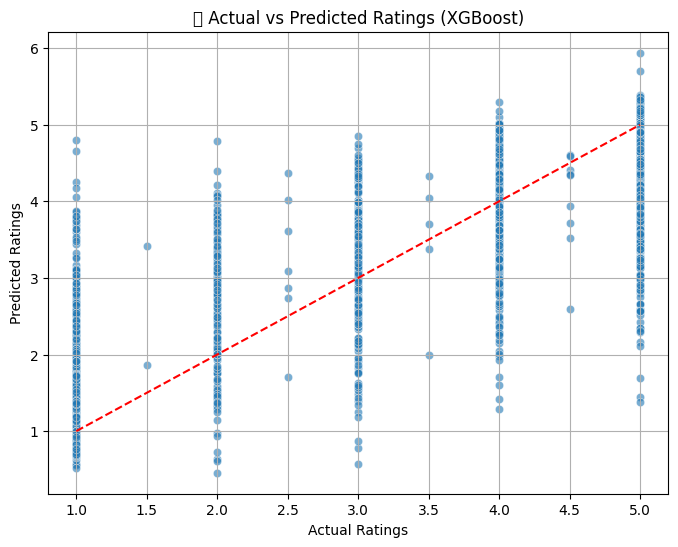

C:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


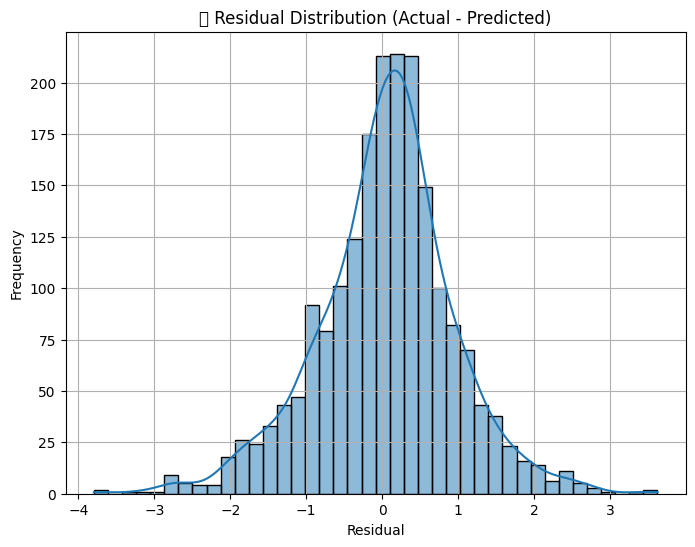

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Scatter Plot: Actual vs Predicted ---
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_xgb, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Perfect prediction line
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("📊 Actual vs Predicted Ratings (XGBoost)")
plt.grid(True)
plt.show()

# --- 2. Residual Plot ---
residuals = y_test - y_pred_xgb
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=40, kde=True)
plt.title("🔍 Residual Distribution (Actual - Predicted)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


# According to the MSE and R square value, we can confirm that the XGBoost model showed the best results and is therefore the best model 